<a href="https://colab.research.google.com/github/Fulmenius/Predicting-antibody-escape-with-ML/blob/main_script/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install xgboost
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

sns.set()

# Importing models and training loop
%run "/content/drive/MyDrive/Colab Notebooks/models/one_hot_CNN.ipynb"
%run "/content/drive/MyDrive/Colab Notebooks/models/one_hot_XGBoost.ipynb"
%run "/content/drive/MyDrive/Colab Notebooks/models/ProtT5_CNN.ipynb"
%run "/content/drive/MyDrive/Colab Notebooks/models/ProtT5_XGBoost.ipynb"
%run "/content/drive/MyDrive/Colab Notebooks/models/training_routine.ipynb"
%run "/content/drive/MyDrive/Colab Notebooks/models/utils.ipynb"

one_hot_CNN is loaded
one_hot_XGBoost is loaded
ProtT5_CNN is loaded
ProtT5_XGBoost is loaded
Training routine is loaded
utils are loaded


In [2]:
import pandas as pd

# Importing data
ACE2_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/ACE2_train_data.csv")
ACE2_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/ACE2_test_data.csv")
LY16_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/LY16_train_data.csv")
LY16_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/LY16_test_data.csv")
LY555_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/LY555_test_data.csv")
LY555_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/LY555_train_data.csv")
REGN33_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/REGN33_train_data.csv")
REGN33_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/REGN33_test_data.csv")
REGN87_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/REGN87_train_data.csv")
REGN87_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/REGN87_test_data.csv")

LY16_embedding_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/LY16_embedding_full_train.csv")
LY16_embedding_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/LY16_embedding_full_test.csv")
LY555_embedding_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/LY555_embedding_full_train.csv")
LY555_embedding_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/LY555_embedding_full_test.csv")
REGN33_embedding_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/REGN33_embedding_full_train.csv")
REGN33_embedding_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/REGN33_embedding_full_test.csv")
REGN87_embedding_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/REGN87_embedding_full_train.csv")
REGN87_embedding_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/REGN87_embedding_full_test.csv")

train_antibodies = [LY16_train, LY555_train, REGN33_train, REGN87_train]
test_antibodies = [LY16_test, LY555_test, REGN33_test, REGN87_test]

train_embeddings = [LY16_embedding_train, LY555_embedding_train, REGN33_embedding_train, REGN87_embedding_train]
test_embeddings = [LY16_embedding_test, LY555_embedding_test, REGN33_embedding_test, REGN87_embedding_test]


In [3]:
# General settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = 20  # number of unique characters in our sequences
output_dim = 1

antibodies = ["LY16", "LY555", "REGN33", "REGN87"]
models = {
    "CNN": ConvNet(),
    "XGBoost": xgb.XGBClassifier(
        objective="binary:logistic", 
        random_state=42,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=9,
        gamma=1,
        reg_alpha=0.005
    ),
    "ProtT5_CNN": ConvNet1D(),
    "ProtT5_XGBoost": xgb.XGBClassifier(
        objective="binary:logistic", 
        random_state=42,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=9,
        gamma=1,
        reg_alpha=0.005
    )
}
results = {model: {antibody: [] for antibody in antibodies} for model in models}

In [4]:
from tqdm import tqdm

for i, (train_antibody, test_antibody, train_embedding, test_embedding) in tqdm(enumerate(zip(train_antibodies, test_antibodies, train_embeddings, test_embeddings)), total=len(train_antibodies)):
    for _ in range(10):
        for model_name, model in models.items():
            if model_name == "ProtT5_CNN" or model_name == "ProtT5_XGBoost":
                train_loader = prepare_t5_data(train_embedding, sample_size=1000)
                test_loader = prepare_t5_data(test_embedding, sample_size=1000)
            else:
                train_loader = prepare_data(train_antibody, sample_size=1000)
                test_loader = prepare_data(test_antibody, sample_size=1000)

            if model_name == "XGBoost" or model_name == "ProtT5_XGBoost":
                # Flatten the sequences
                X_train = torch.vstack([x for x, y in train_loader]).reshape(-1, 1024).numpy() if model_name == "ProtT5_XGBoost" else torch.vstack([x for x, y in train_loader]).reshape(-1, 24*20).numpy()
                y_train = torch.hstack([y for x, y in train_loader]).numpy()
                X_test = torch.vstack([x for x, y in test_loader]).reshape(-1, 1024).numpy() if model_name == "ProtT5_XGBoost" else torch.vstack([x for x, y in test_loader]).reshape(-1, 24*20).numpy()
                y_test = torch.hstack([y for x, y in test_loader]).numpy()

                # Train the XGBoost model
                model.fit(X_train, y_train)

                # Predict on test set
                y_pred = model.predict_proba(X_test)[:, 1]

                # Calculate ROC/AUC score
                score = roc_auc_score(y_test, y_pred)
            else:
                # Handle other models (CNN and ProtT5_CNN) similarly
                criterion = nn.BCEWithLogitsLoss()
                learning_rate = 1e-3
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                model = model.to(device)
                score = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=20)
            results[model_name][antibodies[i]].append(score)


  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-1-84c72daddc24>:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  sequences = torch.tensor(sequences).float() # Changed this line


Epoch 1/20, Training Loss: 0.6368
Epoch 2/20, Training Loss: 0.4788
Epoch 3/20, Training Loss: 0.4223
Epoch 4/20, Training Loss: 0.3734
Epoch 5/20, Training Loss: 0.3451
Epoch 6/20, Training Loss: 0.3111
Epoch 7/20, Training Loss: 0.2780
Epoch 8/20, Training Loss: 0.2488
Epoch 9/20, Training Loss: 0.2279
Epoch 10/20, Training Loss: 0.2070
Epoch 11/20, Training Loss: 0.1674
Epoch 12/20, Training Loss: 0.1591
Epoch 13/20, Training Loss: 0.1512
Epoch 14/20, Training Loss: 0.1390
Epoch 15/20, Training Loss: 0.1155
Epoch 16/20, Training Loss: 0.0983
Epoch 17/20, Training Loss: 0.0871
Epoch 18/20, Training Loss: 0.0886
Epoch 19/20, Training Loss: 0.0924
Epoch 20/20, Training Loss: 0.0803
ROC/AUC Score: 0.8472
Epoch 1/20, Training Loss: 0.6716
Epoch 2/20, Training Loss: 0.4889
Epoch 3/20, Training Loss: 0.4209
Epoch 4/20, Training Loss: 0.3284
Epoch 5/20, Training Loss: 0.2444
Epoch 6/20, Training Loss: 0.1850
Epoch 7/20, Training Loss: 0.1420
Epoch 8/20, Training Loss: 0.0915
Epoch 9/20, Tra

 25%|██▌       | 1/4 [07:40<23:01, 460.66s/it]

Epoch 1/20, Training Loss: 0.6052
Epoch 2/20, Training Loss: 0.4532
Epoch 3/20, Training Loss: 0.3998
Epoch 4/20, Training Loss: 0.3539
Epoch 5/20, Training Loss: 0.3133
Epoch 6/20, Training Loss: 0.2799
Epoch 7/20, Training Loss: 0.2515
Epoch 8/20, Training Loss: 0.2242
Epoch 9/20, Training Loss: 0.2067
Epoch 10/20, Training Loss: 0.1927
Epoch 11/20, Training Loss: 0.1771
Epoch 12/20, Training Loss: 0.1616
Epoch 13/20, Training Loss: 0.1368
Epoch 14/20, Training Loss: 0.1295
Epoch 15/20, Training Loss: 0.1236
Epoch 16/20, Training Loss: 0.1113
Epoch 17/20, Training Loss: 0.1083
Epoch 18/20, Training Loss: 0.1014
Epoch 19/20, Training Loss: 0.0979
Epoch 20/20, Training Loss: 0.0859
ROC/AUC Score: 0.8866
Epoch 1/20, Training Loss: 0.5823
Epoch 2/20, Training Loss: 0.4206
Epoch 3/20, Training Loss: 0.3310
Epoch 4/20, Training Loss: 0.2874
Epoch 5/20, Training Loss: 0.2125
Epoch 6/20, Training Loss: 0.1712
Epoch 7/20, Training Loss: 0.1613
Epoch 8/20, Training Loss: 0.1442
Epoch 9/20, Tra

 50%|█████     | 2/4 [15:05<15:02, 451.45s/it]

Epoch 1/20, Training Loss: 0.6147
Epoch 2/20, Training Loss: 0.4794
Epoch 3/20, Training Loss: 0.4241
Epoch 4/20, Training Loss: 0.3864
Epoch 5/20, Training Loss: 0.3314
Epoch 6/20, Training Loss: 0.2944
Epoch 7/20, Training Loss: 0.2655
Epoch 8/20, Training Loss: 0.2431
Epoch 9/20, Training Loss: 0.2134
Epoch 10/20, Training Loss: 0.1854
Epoch 11/20, Training Loss: 0.1685
Epoch 12/20, Training Loss: 0.1428
Epoch 13/20, Training Loss: 0.1216
Epoch 14/20, Training Loss: 0.1168
Epoch 15/20, Training Loss: 0.0993
Epoch 16/20, Training Loss: 0.0894
Epoch 17/20, Training Loss: 0.0844
Epoch 18/20, Training Loss: 0.0759
Epoch 19/20, Training Loss: 0.0790
Epoch 20/20, Training Loss: 0.0578
ROC/AUC Score: 0.7572
Epoch 1/20, Training Loss: 0.6064
Epoch 2/20, Training Loss: 0.4643
Epoch 3/20, Training Loss: 0.3629
Epoch 4/20, Training Loss: 0.2769
Epoch 5/20, Training Loss: 0.2463
Epoch 6/20, Training Loss: 0.1683
Epoch 7/20, Training Loss: 0.1396
Epoch 8/20, Training Loss: 0.1032
Epoch 9/20, Tra

 75%|███████▌  | 3/4 [22:27<07:27, 447.15s/it]

Epoch 1/20, Training Loss: 0.4263
Epoch 2/20, Training Loss: 0.2803
Epoch 3/20, Training Loss: 0.2436
Epoch 4/20, Training Loss: 0.2093
Epoch 5/20, Training Loss: 0.1889
Epoch 6/20, Training Loss: 0.1598
Epoch 7/20, Training Loss: 0.1474
Epoch 8/20, Training Loss: 0.1297
Epoch 9/20, Training Loss: 0.1093
Epoch 10/20, Training Loss: 0.0895
Epoch 11/20, Training Loss: 0.0845
Epoch 12/20, Training Loss: 0.0710
Epoch 13/20, Training Loss: 0.0628
Epoch 14/20, Training Loss: 0.0520
Epoch 15/20, Training Loss: 0.0546
Epoch 16/20, Training Loss: 0.0500
Epoch 17/20, Training Loss: 0.0421
Epoch 18/20, Training Loss: 0.0337
Epoch 19/20, Training Loss: 0.0350
Epoch 20/20, Training Loss: 0.0330
ROC/AUC Score: 0.9461
Epoch 1/20, Training Loss: 0.4290
Epoch 2/20, Training Loss: 0.2731
Epoch 3/20, Training Loss: 0.2207
Epoch 4/20, Training Loss: 0.1814
Epoch 5/20, Training Loss: 0.1357
Epoch 6/20, Training Loss: 0.1135
Epoch 7/20, Training Loss: 0.0905
Epoch 8/20, Training Loss: 0.0719
Epoch 9/20, Tra

100%|██████████| 4/4 [29:45<00:00, 446.48s/it]


CNN model:
LY16: [0.8471715036197067, 0.8523361569148404, 0.8093169316931693, 0.8469582053251408, 0.8161945751176058, 0.8228826579604379, 0.851228, 0.8468701831648482, 0.8492249224922493, 0.8653905390539053]
LY555: [0.8866327444956476, 0.8829900887887676, 0.8428330779172453, 0.873881422798127, 0.9033658154121864, 0.8662029918636683, 0.8501344193563872, 0.8870397337216558, 0.8532546082949308, 0.8436478954449356]
REGN33: [0.7572010369493207, 0.8606148707906339, 0.7700990803963217, 0.8082640000000001, 0.798216735802489, 0.8293607128709702, 0.8488543266769073, 0.867739818135246, 0.8595882183355756, 0.8849029478076658]
REGN87: [0.9460722344017539, 0.9606734152286945, 0.9432214646949618, 0.9579847756410257, 0.9672011427837699, 0.9488779800840964, 0.9355925279161793, 0.9522245207447213, 0.9400222688604432, 0.9568647129666801]
XGBoost model:
LY16: [0.5016826923076922, 0.4751331047917725, 0.5180238023802379, 0.4884862166824774, 0.5004181672669068, 0.5099666378648233, 0.5041368928141309, 0.44295

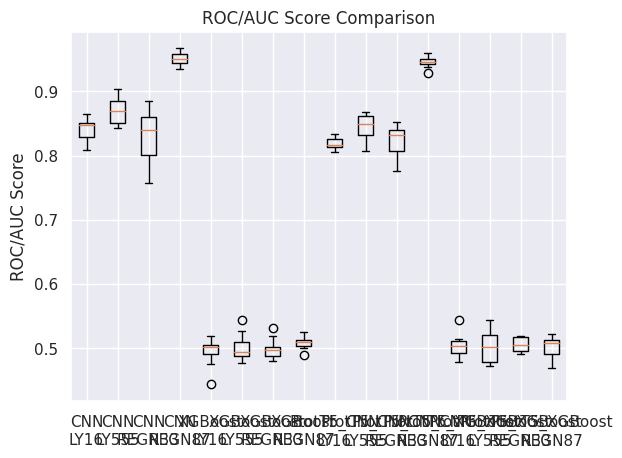

In [5]:
# Print the results
for model, scores in results.items():
    print(f"{model} model:")
    for antibody, score in scores.items():
        print(f"{antibody}: {score}")

# Create boxplot
fig, ax = plt.subplots()
model_names = list(results.keys())
data = [results[model_name][antibody] for model_name in model_names for antibody in antibodies]
ax.boxplot(data, labels=[f"{model_name}\n{antibody}" for model_name in model_names for antibody in antibodies])

plt.title('ROC/AUC Score Comparison')
plt.ylabel('ROC/AUC Score')
plt.show()

CNN model:
LY16: [0.8471715036197067, 0.8523361569148404, 0.8093169316931693, 0.8469582053251408, 0.8161945751176058, 0.8228826579604379, 0.851228, 0.8468701831648482, 0.8492249224922493, 0.8653905390539053, 0.7898558278273142, 0.8350309254382272, 0.8475060408698853, 0.8550176802828845, 0.8259916212852964, 0.8177728144225496, 0.8029347839139258, 0.8019054089026916, 0.8237635338586713, 0.8646544654465446, 0.8676027602760275, 0.8667472028993044, 0.8635111896773572]
LY555: [0.8866327444956476, 0.8829900887887676, 0.8428330779172453, 0.873881422798127, 0.9033658154121864, 0.8662029918636683, 0.8501344193563872, 0.8870397337216558, 0.8532546082949308, 0.8436478954449356, 0.8978475913903655, 0.9044292681365546, 0.8731163532599111, 0.8853915415661664, 0.8600020050125314, 0.8825139345147828, 0.8434054503848553, 0.8873927392739273, 0.8410404392930327, 0.9267882794025265]
REGN33: [0.7572010369493207, 0.8606148707906339, 0.7700990803963217, 0.8082640000000001, 0.798216735802489, 0.829360712870970

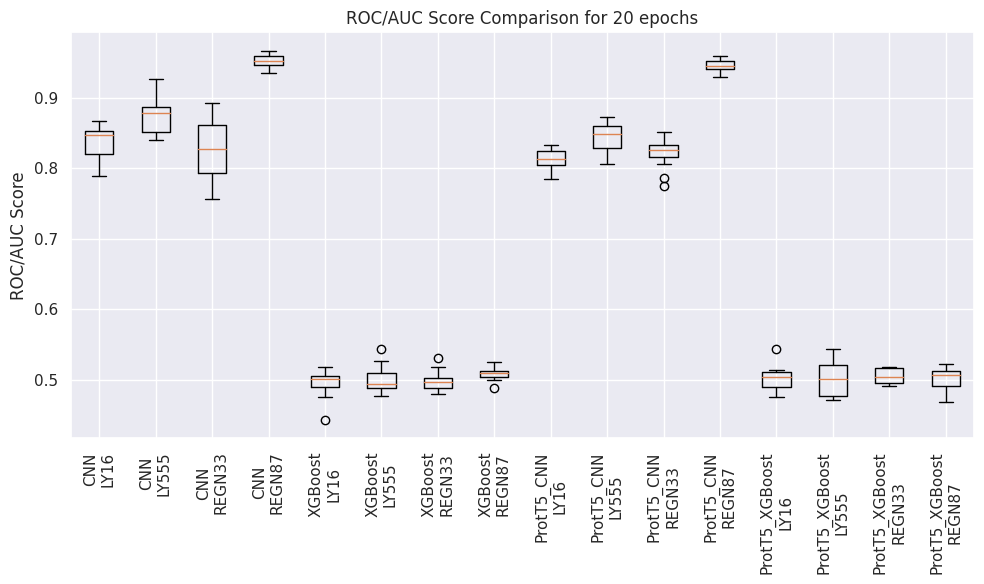

In [13]:
import matplotlib.pyplot as plt

# Print the results
for model, scores in results.items():
    print(f"{model} model:")
    for antibody, score in scores.items():
        print(f"{antibody}: {score}")

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as per your needs
model_names = list(results.keys())
data = [results[model_name][antibody] for model_name in model_names for antibody in antibodies]
boxplot = ax.boxplot(data, labels=[f"{model_name}\n{antibody}" for model_name in model_names for antibody in antibodies])

# Rotate the labels
plt.xticks(rotation=90)

plt.title('ROC/AUC Score Comparison for 20 epochs')
plt.ylabel('ROC/AUC Score')
plt.tight_layout()  # Adjust the layout to prevent overlapping labels
plt.savefig('20_epochs_final_plot.png')
plt.show()

In [21]:
import csv
# Save the results as a CSV file
with open('results_20_epochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for key, value in results.items():
        writer.writerow([key, value])

In [10]:
models_10_epochs = {
    "CNN": ConvNet(),
    "ProtT5_CNN": ConvNet1D()
}

results_10_epochs = {model: {antibody: [] for antibody in antibodies} for model in models_10_epochs}

from tqdm import tqdm

for i, (train_antibody, test_antibody, train_embedding, test_embedding) in tqdm(enumerate(zip(train_antibodies, test_antibodies, train_embeddings, test_embeddings)), total=len(train_antibodies)):
    for _ in tqdm(range(10)):
        for model_name, model in models_10_epochs.items():
            if model_name == "ProtT5_CNN" or model_name == "ProtT5_XGBoost":
                train_loader = prepare_t5_data(train_embedding, sample_size=1000)
                test_loader = prepare_t5_data(test_embedding, sample_size=1000)
            else:
                train_loader = prepare_data(train_antibody, sample_size=1000)
                test_loader = prepare_data(test_antibody, sample_size=1000)

            if model_name == "XGBoost" or model_name == "ProtT5_XGBoost":
                # Flatten the sequences
                X_train = torch.vstack([x for x, y in train_loader]).reshape(-1, 1024).numpy() if model_name == "ProtT5_XGBoost" else torch.vstack([x for x, y in train_loader]).reshape(-1, 24*20).numpy()
                y_train = torch.hstack([y for x, y in train_loader]).numpy()
                X_test = torch.vstack([x for x, y in test_loader]).reshape(-1, 1024).numpy() if model_name == "ProtT5_XGBoost" else torch.vstack([x for x, y in test_loader]).reshape(-1, 24*20).numpy()
                y_test = torch.hstack([y for x, y in test_loader]).numpy()

                # Train the XGBoost model
                model.fit(X_train, y_train)

                # Predict on test set
                y_pred = model.predict_proba(X_test)[:, 1]

                # Calculate ROC/AUC score
                score = roc_auc_score(y_test, y_pred)
            else:
                # Handle other models (CNN and ProtT5_CNN) similarly
                criterion = nn.BCEWithLogitsLoss()
                learning_rate = 1e-3
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                model = model.to(device)
                score = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10)
            results[model_name][antibodies[i]].append(score)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.6067
Epoch 2/10, Training Loss: 0.4691
Epoch 3/10, Training Loss: 0.4050
Epoch 4/10, Training Loss: 0.3528
Epoch 5/10, Training Loss: 0.3082
Epoch 6/10, Training Loss: 0.2681
Epoch 7/10, Training Loss: 0.2261
Epoch 8/10, Training Loss: 0.2027
Epoch 9/10, Training Loss: 0.1707
Epoch 10/10, Training Loss: 0.1362
ROC/AUC Score: 0.8550
Epoch 1/10, Training Loss: 0.5939
Epoch 2/10, Training Loss: 0.4265
Epoch 3/10, Training Loss: 0.3500
Epoch 4/10, Training Loss: 0.2887
Epoch 5/10, Training Loss: 0.2382
Epoch 6/10, Training Loss: 0.1826
Epoch 7/10, Training Loss: 0.1600
Epoch 8/10, Training Loss: 0.1353
Epoch 9/10, Training Loss: 0.1255
Epoch 10/10, Training Loss: 0.1028



 10%|█         | 1/10 [00:05<00:50,  5.59s/it]

ROC/AUC Score: 0.8219
Epoch 1/10, Training Loss: 0.6223
Epoch 2/10, Training Loss: 0.4613
Epoch 3/10, Training Loss: 0.3941
Epoch 4/10, Training Loss: 0.3552
Epoch 5/10, Training Loss: 0.3153
Epoch 6/10, Training Loss: 0.2826
Epoch 7/10, Training Loss: 0.2456
Epoch 8/10, Training Loss: 0.2151
Epoch 9/10, Training Loss: 0.1828
Epoch 10/10, Training Loss: 0.1586
ROC/AUC Score: 0.8260
Epoch 1/10, Training Loss: 0.6503
Epoch 2/10, Training Loss: 0.4953
Epoch 3/10, Training Loss: 0.4122
Epoch 4/10, Training Loss: 0.3456
Epoch 5/10, Training Loss: 0.3196
Epoch 6/10, Training Loss: 0.2530
Epoch 7/10, Training Loss: 0.1684
Epoch 8/10, Training Loss: 0.1594
Epoch 9/10, Training Loss: 0.1526
Epoch 10/10, Training Loss: 0.1308



 20%|██        | 2/10 [00:09<00:37,  4.73s/it]

ROC/AUC Score: 0.8332
Epoch 1/10, Training Loss: 0.6455
Epoch 2/10, Training Loss: 0.5098
Epoch 3/10, Training Loss: 0.4485
Epoch 4/10, Training Loss: 0.3971
Epoch 5/10, Training Loss: 0.3631
Epoch 6/10, Training Loss: 0.3262
Epoch 7/10, Training Loss: 0.2794
Epoch 8/10, Training Loss: 0.2626
Epoch 9/10, Training Loss: 0.2316
Epoch 10/10, Training Loss: 0.1878
ROC/AUC Score: 0.8178
Epoch 1/10, Training Loss: 0.6145
Epoch 2/10, Training Loss: 0.4540
Epoch 3/10, Training Loss: 0.3758
Epoch 4/10, Training Loss: 0.3199
Epoch 5/10, Training Loss: 0.2750
Epoch 6/10, Training Loss: 0.2119
Epoch 7/10, Training Loss: 0.2023
Epoch 8/10, Training Loss: 0.1396
Epoch 9/10, Training Loss: 0.1086
Epoch 10/10, Training Loss: 0.1250



 30%|███       | 3/10 [00:13<00:31,  4.46s/it]

ROC/AUC Score: 0.7887
Epoch 1/10, Training Loss: 0.6311
Epoch 2/10, Training Loss: 0.5028
Epoch 3/10, Training Loss: 0.4490
Epoch 4/10, Training Loss: 0.4102
Epoch 5/10, Training Loss: 0.3781
Epoch 6/10, Training Loss: 0.3376
Epoch 7/10, Training Loss: 0.2949
Epoch 8/10, Training Loss: 0.2759
Epoch 9/10, Training Loss: 0.2305
Epoch 10/10, Training Loss: 0.1948
ROC/AUC Score: 0.8029
Epoch 1/10, Training Loss: 0.6368
Epoch 2/10, Training Loss: 0.4787
Epoch 3/10, Training Loss: 0.4072
Epoch 4/10, Training Loss: 0.3394
Epoch 5/10, Training Loss: 0.3069
Epoch 6/10, Training Loss: 0.2663
Epoch 7/10, Training Loss: 0.2284
Epoch 8/10, Training Loss: 0.1625
Epoch 9/10, Training Loss: 0.1321
Epoch 10/10, Training Loss: 0.1415



 40%|████      | 4/10 [00:19<00:29,  4.91s/it]

ROC/AUC Score: 0.8235
Epoch 1/10, Training Loss: 0.6329
Epoch 2/10, Training Loss: 0.4991
Epoch 3/10, Training Loss: 0.4350
Epoch 4/10, Training Loss: 0.3867
Epoch 5/10, Training Loss: 0.3394
Epoch 6/10, Training Loss: 0.3037
Epoch 7/10, Training Loss: 0.2717
Epoch 8/10, Training Loss: 0.2287
Epoch 9/10, Training Loss: 0.2073
Epoch 10/10, Training Loss: 0.1972
ROC/AUC Score: 0.8019
Epoch 1/10, Training Loss: 0.6095
Epoch 2/10, Training Loss: 0.4344
Epoch 3/10, Training Loss: 0.3688
Epoch 4/10, Training Loss: 0.3168
Epoch 5/10, Training Loss: 0.2109
Epoch 6/10, Training Loss: 0.1535
Epoch 7/10, Training Loss: 0.1673
Epoch 8/10, Training Loss: 0.1535
Epoch 9/10, Training Loss: 0.1231
Epoch 10/10, Training Loss: 0.1093



 50%|█████     | 5/10 [00:23<00:23,  4.62s/it]

ROC/AUC Score: 0.7940
Epoch 1/10, Training Loss: 0.6253
Epoch 2/10, Training Loss: 0.5120
Epoch 3/10, Training Loss: 0.4584
Epoch 4/10, Training Loss: 0.4180
Epoch 5/10, Training Loss: 0.3778
Epoch 6/10, Training Loss: 0.3471
Epoch 7/10, Training Loss: 0.3115
Epoch 8/10, Training Loss: 0.2922
Epoch 9/10, Training Loss: 0.2646
Epoch 10/10, Training Loss: 0.2293
ROC/AUC Score: 0.8238
Epoch 1/10, Training Loss: 0.5942
Epoch 2/10, Training Loss: 0.4432
Epoch 3/10, Training Loss: 0.3774
Epoch 4/10, Training Loss: 0.2990
Epoch 5/10, Training Loss: 0.2539
Epoch 6/10, Training Loss: 0.1904
Epoch 7/10, Training Loss: 0.1573
Epoch 8/10, Training Loss: 0.1478
Epoch 9/10, Training Loss: 0.1101
Epoch 10/10, Training Loss: 0.0707



 60%|██████    | 6/10 [00:27<00:17,  4.44s/it]

ROC/AUC Score: 0.8052
Epoch 1/10, Training Loss: 0.6305
Epoch 2/10, Training Loss: 0.5222
Epoch 3/10, Training Loss: 0.4583
Epoch 4/10, Training Loss: 0.4139
Epoch 5/10, Training Loss: 0.3656
Epoch 6/10, Training Loss: 0.3298
Epoch 7/10, Training Loss: 0.2900
Epoch 8/10, Training Loss: 0.2583
Epoch 9/10, Training Loss: 0.2400
Epoch 10/10, Training Loss: 0.2071
ROC/AUC Score: 0.8647
Epoch 1/10, Training Loss: 0.6354
Epoch 2/10, Training Loss: 0.4683
Epoch 3/10, Training Loss: 0.3873
Epoch 4/10, Training Loss: 0.3215
Epoch 5/10, Training Loss: 0.2845
Epoch 6/10, Training Loss: 0.2078
Epoch 7/10, Training Loss: 0.1536
Epoch 8/10, Training Loss: 0.1430
Epoch 9/10, Training Loss: 0.1198
Epoch 10/10, Training Loss: 0.1098



 70%|███████   | 7/10 [00:33<00:14,  4.77s/it]

ROC/AUC Score: 0.7885
Epoch 1/10, Training Loss: 0.6222
Epoch 2/10, Training Loss: 0.4867
Epoch 3/10, Training Loss: 0.4147
Epoch 4/10, Training Loss: 0.3654
Epoch 5/10, Training Loss: 0.3221
Epoch 6/10, Training Loss: 0.2843
Epoch 7/10, Training Loss: 0.2520
Epoch 8/10, Training Loss: 0.2225
Epoch 9/10, Training Loss: 0.2040
Epoch 10/10, Training Loss: 0.1626
ROC/AUC Score: 0.8676
Epoch 1/10, Training Loss: 0.6239
Epoch 2/10, Training Loss: 0.4820
Epoch 3/10, Training Loss: 0.4197
Epoch 4/10, Training Loss: 0.3617
Epoch 5/10, Training Loss: 0.2974
Epoch 6/10, Training Loss: 0.2563
Epoch 7/10, Training Loss: 0.2317
Epoch 8/10, Training Loss: 0.2050
Epoch 9/10, Training Loss: 0.1657
Epoch 10/10, Training Loss: 0.1189



 80%|████████  | 8/10 [00:37<00:09,  4.56s/it]

ROC/AUC Score: 0.8138
Epoch 1/10, Training Loss: 0.6248
Epoch 2/10, Training Loss: 0.5000
Epoch 3/10, Training Loss: 0.4311
Epoch 4/10, Training Loss: 0.3843
Epoch 5/10, Training Loss: 0.3545
Epoch 6/10, Training Loss: 0.3172
Epoch 7/10, Training Loss: 0.2834
Epoch 8/10, Training Loss: 0.2543
Epoch 9/10, Training Loss: 0.2262
Epoch 10/10, Training Loss: 0.2073
ROC/AUC Score: 0.8667
Epoch 1/10, Training Loss: 0.6222
Epoch 2/10, Training Loss: 0.4708
Epoch 3/10, Training Loss: 0.3893
Epoch 4/10, Training Loss: 0.3505
Epoch 5/10, Training Loss: 0.2742
Epoch 6/10, Training Loss: 0.1817
Epoch 7/10, Training Loss: 0.1703
Epoch 8/10, Training Loss: 0.1448
Epoch 9/10, Training Loss: 0.0951
Epoch 10/10, Training Loss: 0.0792



 90%|█████████ | 9/10 [00:41<00:04,  4.41s/it]

ROC/AUC Score: 0.7876
Epoch 1/10, Training Loss: 0.6189
Epoch 2/10, Training Loss: 0.4920
Epoch 3/10, Training Loss: 0.4389
Epoch 4/10, Training Loss: 0.3905
Epoch 5/10, Training Loss: 0.3424
Epoch 6/10, Training Loss: 0.3144
Epoch 7/10, Training Loss: 0.2832
Epoch 8/10, Training Loss: 0.2561
Epoch 9/10, Training Loss: 0.2245
Epoch 10/10, Training Loss: 0.2058
ROC/AUC Score: 0.8635
Epoch 1/10, Training Loss: 0.6079
Epoch 2/10, Training Loss: 0.4502
Epoch 3/10, Training Loss: 0.4000
Epoch 4/10, Training Loss: 0.3108
Epoch 5/10, Training Loss: 0.2576
Epoch 6/10, Training Loss: 0.1921
Epoch 7/10, Training Loss: 0.1286
Epoch 8/10, Training Loss: 0.1058
Epoch 9/10, Training Loss: 0.1093
Epoch 10/10, Training Loss: 0.1286



 25%|██▌       | 1/4 [00:46<02:20, 46.81s/it]

ROC/AUC Score: 0.7843



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.5969
Epoch 2/10, Training Loss: 0.4651
Epoch 3/10, Training Loss: 0.4029
Epoch 4/10, Training Loss: 0.3527
Epoch 5/10, Training Loss: 0.3182
Epoch 6/10, Training Loss: 0.2888
Epoch 7/10, Training Loss: 0.2557
Epoch 8/10, Training Loss: 0.2382
Epoch 9/10, Training Loss: 0.2202
Epoch 10/10, Training Loss: 0.1941
ROC/AUC Score: 0.8978
Epoch 1/10, Training Loss: 0.6402
Epoch 2/10, Training Loss: 0.4824
Epoch 3/10, Training Loss: 0.3813
Epoch 4/10, Training Loss: 0.3260
Epoch 5/10, Training Loss: 0.2645
Epoch 6/10, Training Loss: 0.2095
Epoch 7/10, Training Loss: 0.1601
Epoch 8/10, Training Loss: 0.1046
Epoch 9/10, Training Loss: 0.1298
Epoch 10/10, Training Loss: 0.0983



 10%|█         | 1/10 [00:04<00:36,  4.07s/it]

ROC/AUC Score: 0.8737
Epoch 1/10, Training Loss: 0.6221
Epoch 2/10, Training Loss: 0.5026
Epoch 3/10, Training Loss: 0.4324
Epoch 4/10, Training Loss: 0.3776
Epoch 5/10, Training Loss: 0.3411
Epoch 6/10, Training Loss: 0.3110
Epoch 7/10, Training Loss: 0.2805
Epoch 8/10, Training Loss: 0.2367
Epoch 9/10, Training Loss: 0.2177
Epoch 10/10, Training Loss: 0.1934
ROC/AUC Score: 0.9044
Epoch 1/10, Training Loss: 0.6280
Epoch 2/10, Training Loss: 0.4898
Epoch 3/10, Training Loss: 0.4059
Epoch 4/10, Training Loss: 0.3252
Epoch 5/10, Training Loss: 0.2353
Epoch 6/10, Training Loss: 0.1944
Epoch 7/10, Training Loss: 0.1974
Epoch 8/10, Training Loss: 0.1428
Epoch 9/10, Training Loss: 0.1509
Epoch 10/10, Training Loss: 0.1167



 20%|██        | 2/10 [00:08<00:33,  4.14s/it]

ROC/AUC Score: 0.8419
Epoch 1/10, Training Loss: 0.6094
Epoch 2/10, Training Loss: 0.4656
Epoch 3/10, Training Loss: 0.3982
Epoch 4/10, Training Loss: 0.3607
Epoch 5/10, Training Loss: 0.3195
Epoch 6/10, Training Loss: 0.2795
Epoch 7/10, Training Loss: 0.2519
Epoch 8/10, Training Loss: 0.2244
Epoch 9/10, Training Loss: 0.1935
Epoch 10/10, Training Loss: 0.1836
ROC/AUC Score: 0.8731
Epoch 1/10, Training Loss: 0.6093
Epoch 2/10, Training Loss: 0.4534
Epoch 3/10, Training Loss: 0.3698
Epoch 4/10, Training Loss: 0.3097
Epoch 5/10, Training Loss: 0.2619
Epoch 6/10, Training Loss: 0.1866
Epoch 7/10, Training Loss: 0.1376
Epoch 8/10, Training Loss: 0.1810
Epoch 9/10, Training Loss: 0.1485
Epoch 10/10, Training Loss: 0.1004



 30%|███       | 3/10 [00:13<00:33,  4.75s/it]

ROC/AUC Score: 0.8131
Epoch 1/10, Training Loss: 0.6112
Epoch 2/10, Training Loss: 0.5042
Epoch 3/10, Training Loss: 0.4500
Epoch 4/10, Training Loss: 0.3983
Epoch 5/10, Training Loss: 0.3572
Epoch 6/10, Training Loss: 0.3180
Epoch 7/10, Training Loss: 0.2814
Epoch 8/10, Training Loss: 0.2798
Epoch 9/10, Training Loss: 0.2524
Epoch 10/10, Training Loss: 0.2269
ROC/AUC Score: 0.8854
Epoch 1/10, Training Loss: 0.6468
Epoch 2/10, Training Loss: 0.4987
Epoch 3/10, Training Loss: 0.4074
Epoch 4/10, Training Loss: 0.3338
Epoch 5/10, Training Loss: 0.2584
Epoch 6/10, Training Loss: 0.2532
Epoch 7/10, Training Loss: 0.2542
Epoch 8/10, Training Loss: 0.1518
Epoch 9/10, Training Loss: 0.1226
Epoch 10/10, Training Loss: 0.1474



 40%|████      | 4/10 [00:17<00:26,  4.46s/it]

ROC/AUC Score: 0.8351
Epoch 1/10, Training Loss: 0.6163
Epoch 2/10, Training Loss: 0.4760
Epoch 3/10, Training Loss: 0.4028
Epoch 4/10, Training Loss: 0.3526
Epoch 5/10, Training Loss: 0.3147
Epoch 6/10, Training Loss: 0.2662
Epoch 7/10, Training Loss: 0.2423
Epoch 8/10, Training Loss: 0.2130
Epoch 9/10, Training Loss: 0.1814
Epoch 10/10, Training Loss: 0.1652
ROC/AUC Score: 0.8600
Epoch 1/10, Training Loss: 0.6011
Epoch 2/10, Training Loss: 0.4322
Epoch 3/10, Training Loss: 0.3403
Epoch 4/10, Training Loss: 0.2548
Epoch 5/10, Training Loss: 0.2184
Epoch 6/10, Training Loss: 0.1633
Epoch 7/10, Training Loss: 0.1133
Epoch 8/10, Training Loss: 0.1256
Epoch 9/10, Training Loss: 0.1160
Epoch 10/10, Training Loss: 0.0874



 50%|█████     | 5/10 [00:21<00:21,  4.32s/it]

ROC/AUC Score: 0.8524
Epoch 1/10, Training Loss: 0.6071
Epoch 2/10, Training Loss: 0.4808
Epoch 3/10, Training Loss: 0.4318
Epoch 4/10, Training Loss: 0.3754
Epoch 5/10, Training Loss: 0.3333
Epoch 6/10, Training Loss: 0.3045
Epoch 7/10, Training Loss: 0.2656
Epoch 8/10, Training Loss: 0.2449
Epoch 9/10, Training Loss: 0.2143
Epoch 10/10, Training Loss: 0.2069
ROC/AUC Score: 0.8825
Epoch 1/10, Training Loss: 0.5834
Epoch 2/10, Training Loss: 0.4038
Epoch 3/10, Training Loss: 0.3205
Epoch 4/10, Training Loss: 0.2491
Epoch 5/10, Training Loss: 0.1818
Epoch 6/10, Training Loss: 0.1662
Epoch 7/10, Training Loss: 0.1217
Epoch 8/10, Training Loss: 0.0740
Epoch 9/10, Training Loss: 0.0712
Epoch 10/10, Training Loss: 0.0968



 60%|██████    | 6/10 [00:27<00:18,  4.71s/it]

ROC/AUC Score: 0.8596
Epoch 1/10, Training Loss: 0.6419
Epoch 2/10, Training Loss: 0.4831
Epoch 3/10, Training Loss: 0.4260
Epoch 4/10, Training Loss: 0.3774
Epoch 5/10, Training Loss: 0.3249
Epoch 6/10, Training Loss: 0.2887
Epoch 7/10, Training Loss: 0.2577
Epoch 8/10, Training Loss: 0.2376
Epoch 9/10, Training Loss: 0.2207
Epoch 10/10, Training Loss: 0.1857
ROC/AUC Score: 0.8434
Epoch 1/10, Training Loss: 0.6078
Epoch 2/10, Training Loss: 0.4234
Epoch 3/10, Training Loss: 0.3537
Epoch 4/10, Training Loss: 0.2824
Epoch 5/10, Training Loss: 0.2088
Epoch 6/10, Training Loss: 0.1643
Epoch 7/10, Training Loss: 0.1338
Epoch 8/10, Training Loss: 0.1419
Epoch 9/10, Training Loss: 0.1344
Epoch 10/10, Training Loss: 0.1314



 70%|███████   | 7/10 [00:31<00:13,  4.52s/it]

ROC/AUC Score: 0.8495
Epoch 1/10, Training Loss: 0.5721
Epoch 2/10, Training Loss: 0.4481
Epoch 3/10, Training Loss: 0.3909
Epoch 4/10, Training Loss: 0.3490
Epoch 5/10, Training Loss: 0.3096
Epoch 6/10, Training Loss: 0.2830
Epoch 7/10, Training Loss: 0.2610
Epoch 8/10, Training Loss: 0.2251
Epoch 9/10, Training Loss: 0.2193
Epoch 10/10, Training Loss: 0.1841
ROC/AUC Score: 0.8874
Epoch 1/10, Training Loss: 0.6212
Epoch 2/10, Training Loss: 0.4723
Epoch 3/10, Training Loss: 0.3826
Epoch 4/10, Training Loss: 0.2994
Epoch 5/10, Training Loss: 0.2374
Epoch 6/10, Training Loss: 0.2067
Epoch 7/10, Training Loss: 0.1504
Epoch 8/10, Training Loss: 0.1200
Epoch 9/10, Training Loss: 0.1569
Epoch 10/10, Training Loss: 0.1587



 80%|████████  | 8/10 [00:35<00:08,  4.38s/it]

ROC/AUC Score: 0.8115
Epoch 1/10, Training Loss: 0.5971
Epoch 2/10, Training Loss: 0.4655
Epoch 3/10, Training Loss: 0.4015
Epoch 4/10, Training Loss: 0.3517
Epoch 5/10, Training Loss: 0.3151
Epoch 6/10, Training Loss: 0.2739
Epoch 7/10, Training Loss: 0.2420
Epoch 8/10, Training Loss: 0.2235
Epoch 9/10, Training Loss: 0.1890
Epoch 10/10, Training Loss: 0.1784
ROC/AUC Score: 0.8410
Epoch 1/10, Training Loss: 0.6559
Epoch 2/10, Training Loss: 0.4859
Epoch 3/10, Training Loss: 0.4020
Epoch 4/10, Training Loss: 0.3286
Epoch 5/10, Training Loss: 0.2712
Epoch 6/10, Training Loss: 0.2535
Epoch 7/10, Training Loss: 0.2163
Epoch 8/10, Training Loss: 0.1367
Epoch 9/10, Training Loss: 0.1142
Epoch 10/10, Training Loss: 0.1451



 90%|█████████ | 9/10 [00:41<00:04,  4.74s/it]

ROC/AUC Score: 0.8596
Epoch 1/10, Training Loss: 0.5683
Epoch 2/10, Training Loss: 0.4238
Epoch 3/10, Training Loss: 0.3515
Epoch 4/10, Training Loss: 0.3105
Epoch 5/10, Training Loss: 0.2778
Epoch 6/10, Training Loss: 0.2392
Epoch 7/10, Training Loss: 0.2012
Epoch 8/10, Training Loss: 0.1962
Epoch 9/10, Training Loss: 0.1760
Epoch 10/10, Training Loss: 0.1602
ROC/AUC Score: 0.9268
Epoch 1/10, Training Loss: 0.6370
Epoch 2/10, Training Loss: 0.4721
Epoch 3/10, Training Loss: 0.3590
Epoch 4/10, Training Loss: 0.2810
Epoch 5/10, Training Loss: 0.2058
Epoch 6/10, Training Loss: 0.1626
Epoch 7/10, Training Loss: 0.1344
Epoch 8/10, Training Loss: 0.1557
Epoch 9/10, Training Loss: 0.0914
Epoch 10/10, Training Loss: 0.0857



 50%|█████     | 2/4 [01:31<01:31, 45.82s/it]

ROC/AUC Score: 0.8265



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.6342
Epoch 2/10, Training Loss: 0.5094
Epoch 3/10, Training Loss: 0.4433
Epoch 4/10, Training Loss: 0.3988
Epoch 5/10, Training Loss: 0.3468
Epoch 6/10, Training Loss: 0.3003
Epoch 7/10, Training Loss: 0.2803
Epoch 8/10, Training Loss: 0.2339
Epoch 9/10, Training Loss: 0.1972
Epoch 10/10, Training Loss: 0.1602
ROC/AUC Score: 0.7576
Epoch 1/10, Training Loss: 0.6197
Epoch 2/10, Training Loss: 0.4616
Epoch 3/10, Training Loss: 0.3600
Epoch 4/10, Training Loss: 0.2914
Epoch 5/10, Training Loss: 0.2513
Epoch 6/10, Training Loss: 0.1887
Epoch 7/10, Training Loss: 0.1364
Epoch 8/10, Training Loss: 0.1362
Epoch 9/10, Training Loss: 0.1111
Epoch 10/10, Training Loss: 0.1107



 10%|█         | 1/10 [00:04<00:36,  4.05s/it]

ROC/AUC Score: 0.8334
Epoch 1/10, Training Loss: 0.5907
Epoch 2/10, Training Loss: 0.4592
Epoch 3/10, Training Loss: 0.3973
Epoch 4/10, Training Loss: 0.3551
Epoch 5/10, Training Loss: 0.3154
Epoch 6/10, Training Loss: 0.2757
Epoch 7/10, Training Loss: 0.2445
Epoch 8/10, Training Loss: 0.2163
Epoch 9/10, Training Loss: 0.2124
Epoch 10/10, Training Loss: 0.1825
ROC/AUC Score: 0.8866
Epoch 1/10, Training Loss: 0.6193
Epoch 2/10, Training Loss: 0.4642
Epoch 3/10, Training Loss: 0.3712
Epoch 4/10, Training Loss: 0.3029
Epoch 5/10, Training Loss: 0.2301
Epoch 6/10, Training Loss: 0.1590
Epoch 7/10, Training Loss: 0.1487
Epoch 8/10, Training Loss: 0.1283
Epoch 9/10, Training Loss: 0.0957
Epoch 10/10, Training Loss: 0.0747



 20%|██        | 2/10 [00:09<00:39,  4.93s/it]

ROC/AUC Score: 0.8345
Epoch 1/10, Training Loss: 0.6114
Epoch 2/10, Training Loss: 0.4708
Epoch 3/10, Training Loss: 0.4069
Epoch 4/10, Training Loss: 0.3649
Epoch 5/10, Training Loss: 0.3218
Epoch 6/10, Training Loss: 0.2948
Epoch 7/10, Training Loss: 0.2584
Epoch 8/10, Training Loss: 0.2326
Epoch 9/10, Training Loss: 0.2076
Epoch 10/10, Training Loss: 0.1797
ROC/AUC Score: 0.8926
Epoch 1/10, Training Loss: 0.6380
Epoch 2/10, Training Loss: 0.4874
Epoch 3/10, Training Loss: 0.4018
Epoch 4/10, Training Loss: 0.3226
Epoch 5/10, Training Loss: 0.2620
Epoch 6/10, Training Loss: 0.2025
Epoch 7/10, Training Loss: 0.1379
Epoch 8/10, Training Loss: 0.1205
Epoch 9/10, Training Loss: 0.1233
Epoch 10/10, Training Loss: 0.1261



 30%|███       | 3/10 [00:13<00:31,  4.55s/it]

ROC/AUC Score: 0.8217
Epoch 1/10, Training Loss: 0.6130
Epoch 2/10, Training Loss: 0.4942
Epoch 3/10, Training Loss: 0.4397
Epoch 4/10, Training Loss: 0.3909
Epoch 5/10, Training Loss: 0.3466
Epoch 6/10, Training Loss: 0.3064
Epoch 7/10, Training Loss: 0.2722
Epoch 8/10, Training Loss: 0.2339
Epoch 9/10, Training Loss: 0.2112
Epoch 10/10, Training Loss: 0.1894
ROC/AUC Score: 0.7603
Epoch 1/10, Training Loss: 0.6494
Epoch 2/10, Training Loss: 0.4853
Epoch 3/10, Training Loss: 0.4036
Epoch 4/10, Training Loss: 0.3133
Epoch 5/10, Training Loss: 0.2338
Epoch 6/10, Training Loss: 0.2293
Epoch 7/10, Training Loss: 0.2057
Epoch 8/10, Training Loss: 0.1564
Epoch 9/10, Training Loss: 0.1315
Epoch 10/10, Training Loss: 0.1127



 40%|████      | 4/10 [00:17<00:26,  4.38s/it]

ROC/AUC Score: 0.8281
Epoch 1/10, Training Loss: 0.6530
Epoch 2/10, Training Loss: 0.4947
Epoch 3/10, Training Loss: 0.4311
Epoch 4/10, Training Loss: 0.3836
Epoch 5/10, Training Loss: 0.3389
Epoch 6/10, Training Loss: 0.3053
Epoch 7/10, Training Loss: 0.2725
Epoch 8/10, Training Loss: 0.2485
Epoch 9/10, Training Loss: 0.2208
Epoch 10/10, Training Loss: 0.1957
ROC/AUC Score: 0.8260
Epoch 1/10, Training Loss: 0.6419
Epoch 2/10, Training Loss: 0.4924
Epoch 3/10, Training Loss: 0.3907
Epoch 4/10, Training Loss: 0.2964
Epoch 5/10, Training Loss: 0.2737
Epoch 6/10, Training Loss: 0.1985
Epoch 7/10, Training Loss: 0.1284
Epoch 8/10, Training Loss: 0.1123
Epoch 9/10, Training Loss: 0.1355
Epoch 10/10, Training Loss: 0.1613



 50%|█████     | 5/10 [00:23<00:24,  4.82s/it]

ROC/AUC Score: 0.8187
Epoch 1/10, Training Loss: 0.6306
Epoch 2/10, Training Loss: 0.4982
Epoch 3/10, Training Loss: 0.4369
Epoch 4/10, Training Loss: 0.3818
Epoch 5/10, Training Loss: 0.3385
Epoch 6/10, Training Loss: 0.2947
Epoch 7/10, Training Loss: 0.2627
Epoch 8/10, Training Loss: 0.2389
Epoch 9/10, Training Loss: 0.1888
Epoch 10/10, Training Loss: 0.1654
ROC/AUC Score: 0.8647
Epoch 1/10, Training Loss: 0.6248
Epoch 2/10, Training Loss: 0.4681
Epoch 3/10, Training Loss: 0.3973
Epoch 4/10, Training Loss: 0.3092
Epoch 5/10, Training Loss: 0.2599
Epoch 6/10, Training Loss: 0.2508
Epoch 7/10, Training Loss: 0.2009
Epoch 8/10, Training Loss: 0.1502
Epoch 9/10, Training Loss: 0.1243
Epoch 10/10, Training Loss: 0.1184



 60%|██████    | 6/10 [00:27<00:18,  4.59s/it]

ROC/AUC Score: 0.8275
Epoch 1/10, Training Loss: 0.5972
Epoch 2/10, Training Loss: 0.4359
Epoch 3/10, Training Loss: 0.3701
Epoch 4/10, Training Loss: 0.3208
Epoch 5/10, Training Loss: 0.2858
Epoch 6/10, Training Loss: 0.2457
Epoch 7/10, Training Loss: 0.2205
Epoch 8/10, Training Loss: 0.1785
Epoch 9/10, Training Loss: 0.1599
Epoch 10/10, Training Loss: 0.1392
ROC/AUC Score: 0.8073
Epoch 1/10, Training Loss: 0.6336
Epoch 2/10, Training Loss: 0.4814
Epoch 3/10, Training Loss: 0.3743
Epoch 4/10, Training Loss: 0.3464
Epoch 5/10, Training Loss: 0.2461
Epoch 6/10, Training Loss: 0.1625
Epoch 7/10, Training Loss: 0.1572
Epoch 8/10, Training Loss: 0.1401
Epoch 9/10, Training Loss: 0.0964
Epoch 10/10, Training Loss: 0.1054



 70%|███████   | 7/10 [00:31<00:13,  4.43s/it]

ROC/AUC Score: 0.8159
Epoch 1/10, Training Loss: 0.6079
Epoch 2/10, Training Loss: 0.4720
Epoch 3/10, Training Loss: 0.4020
Epoch 4/10, Training Loss: 0.3498
Epoch 5/10, Training Loss: 0.3088
Epoch 6/10, Training Loss: 0.2653
Epoch 7/10, Training Loss: 0.2375
Epoch 8/10, Training Loss: 0.2147
Epoch 9/10, Training Loss: 0.1804
Epoch 10/10, Training Loss: 0.1512
ROC/AUC Score: 0.8560
Epoch 1/10, Training Loss: 0.6043
Epoch 2/10, Training Loss: 0.4694
Epoch 3/10, Training Loss: 0.3612
Epoch 4/10, Training Loss: 0.2842
Epoch 5/10, Training Loss: 0.2042
Epoch 6/10, Training Loss: 0.1702
Epoch 7/10, Training Loss: 0.1557
Epoch 8/10, Training Loss: 0.1137
Epoch 9/10, Training Loss: 0.1232
Epoch 10/10, Training Loss: 0.1230



 80%|████████  | 8/10 [00:37<00:09,  4.76s/it]

ROC/AUC Score: 0.8229
Epoch 1/10, Training Loss: 0.6085
Epoch 2/10, Training Loss: 0.5058
Epoch 3/10, Training Loss: 0.4413
Epoch 4/10, Training Loss: 0.3887
Epoch 5/10, Training Loss: 0.3480
Epoch 6/10, Training Loss: 0.3136
Epoch 7/10, Training Loss: 0.2750
Epoch 8/10, Training Loss: 0.2477
Epoch 9/10, Training Loss: 0.2203
Epoch 10/10, Training Loss: 0.2052
ROC/AUC Score: 0.7782
Epoch 1/10, Training Loss: 0.6380
Epoch 2/10, Training Loss: 0.4744
Epoch 3/10, Training Loss: 0.3950
Epoch 4/10, Training Loss: 0.3313
Epoch 5/10, Training Loss: 0.2706
Epoch 6/10, Training Loss: 0.1985
Epoch 7/10, Training Loss: 0.1572
Epoch 8/10, Training Loss: 0.1051
Epoch 9/10, Training Loss: 0.0857
Epoch 10/10, Training Loss: 0.0817



 90%|█████████ | 9/10 [00:41<00:04,  4.55s/it]

ROC/AUC Score: 0.8251
Epoch 1/10, Training Loss: 0.6460
Epoch 2/10, Training Loss: 0.4728
Epoch 3/10, Training Loss: 0.3898
Epoch 4/10, Training Loss: 0.3333
Epoch 5/10, Training Loss: 0.3043
Epoch 6/10, Training Loss: 0.2580
Epoch 7/10, Training Loss: 0.2368
Epoch 8/10, Training Loss: 0.2075
Epoch 9/10, Training Loss: 0.1727
Epoch 10/10, Training Loss: 0.1606
ROC/AUC Score: 0.8038
Epoch 1/10, Training Loss: 0.5941
Epoch 2/10, Training Loss: 0.4289
Epoch 3/10, Training Loss: 0.3394
Epoch 4/10, Training Loss: 0.2979
Epoch 5/10, Training Loss: 0.2125
Epoch 6/10, Training Loss: 0.1556
Epoch 7/10, Training Loss: 0.1093
Epoch 8/10, Training Loss: 0.1035
Epoch 9/10, Training Loss: 0.0847
Epoch 10/10, Training Loss: 0.1873



 75%|███████▌  | 3/4 [02:17<00:45, 45.61s/it]

ROC/AUC Score: 0.8159



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.5161
Epoch 2/10, Training Loss: 0.3253
Epoch 3/10, Training Loss: 0.2521
Epoch 4/10, Training Loss: 0.2105
Epoch 5/10, Training Loss: 0.1867
Epoch 6/10, Training Loss: 0.1603
Epoch 7/10, Training Loss: 0.1435
Epoch 8/10, Training Loss: 0.1211
Epoch 9/10, Training Loss: 0.1152
Epoch 10/10, Training Loss: 0.1124
ROC/AUC Score: 0.9468
Epoch 1/10, Training Loss: 0.3620
Epoch 2/10, Training Loss: 0.2048
Epoch 3/10, Training Loss: 0.1464
Epoch 4/10, Training Loss: 0.1240
Epoch 5/10, Training Loss: 0.0867
Epoch 6/10, Training Loss: 0.0630
Epoch 7/10, Training Loss: 0.0546
Epoch 8/10, Training Loss: 0.0502
Epoch 9/10, Training Loss: 0.0551
Epoch 10/10, Training Loss: 0.0354



 10%|█         | 1/10 [00:05<00:48,  5.37s/it]

ROC/AUC Score: 0.9533
Epoch 1/10, Training Loss: 0.3943
Epoch 2/10, Training Loss: 0.2581
Epoch 3/10, Training Loss: 0.2279
Epoch 4/10, Training Loss: 0.2047
Epoch 5/10, Training Loss: 0.1780
Epoch 6/10, Training Loss: 0.1552
Epoch 7/10, Training Loss: 0.1367
Epoch 8/10, Training Loss: 0.1169
Epoch 9/10, Training Loss: 0.1103
Epoch 10/10, Training Loss: 0.0913
ROC/AUC Score: 0.9541
Epoch 1/10, Training Loss: 0.3916
Epoch 2/10, Training Loss: 0.2427
Epoch 3/10, Training Loss: 0.1792
Epoch 4/10, Training Loss: 0.1430
Epoch 5/10, Training Loss: 0.1082
Epoch 6/10, Training Loss: 0.0817
Epoch 7/10, Training Loss: 0.0805
Epoch 8/10, Training Loss: 0.0514
Epoch 9/10, Training Loss: 0.0326
Epoch 10/10, Training Loss: 0.0366



 20%|██        | 2/10 [00:09<00:36,  4.61s/it]

ROC/AUC Score: 0.9460
Epoch 1/10, Training Loss: 0.5294
Epoch 2/10, Training Loss: 0.3322
Epoch 3/10, Training Loss: 0.2742
Epoch 4/10, Training Loss: 0.2407
Epoch 5/10, Training Loss: 0.2100
Epoch 6/10, Training Loss: 0.1910
Epoch 7/10, Training Loss: 0.1749
Epoch 8/10, Training Loss: 0.1550
Epoch 9/10, Training Loss: 0.1372
Epoch 10/10, Training Loss: 0.1257
ROC/AUC Score: 0.9661
Epoch 1/10, Training Loss: 0.4221
Epoch 2/10, Training Loss: 0.2441
Epoch 3/10, Training Loss: 0.1904
Epoch 4/10, Training Loss: 0.1210
Epoch 5/10, Training Loss: 0.0865
Epoch 6/10, Training Loss: 0.1046
Epoch 7/10, Training Loss: 0.0859
Epoch 8/10, Training Loss: 0.0595
Epoch 9/10, Training Loss: 0.0362
Epoch 10/10, Training Loss: 0.0231



 30%|███       | 3/10 [00:13<00:30,  4.38s/it]

ROC/AUC Score: 0.9537
Epoch 1/10, Training Loss: 0.4443
Epoch 2/10, Training Loss: 0.2680
Epoch 3/10, Training Loss: 0.2196
Epoch 4/10, Training Loss: 0.1954
Epoch 5/10, Training Loss: 0.1719
Epoch 6/10, Training Loss: 0.1500
Epoch 7/10, Training Loss: 0.1295
Epoch 8/10, Training Loss: 0.1098
Epoch 9/10, Training Loss: 0.0972
Epoch 10/10, Training Loss: 0.0835
ROC/AUC Score: 0.9589
Epoch 1/10, Training Loss: 0.4150
Epoch 2/10, Training Loss: 0.2382
Epoch 3/10, Training Loss: 0.1818
Epoch 4/10, Training Loss: 0.1385
Epoch 5/10, Training Loss: 0.1070
Epoch 6/10, Training Loss: 0.0886
Epoch 7/10, Training Loss: 0.0596
Epoch 8/10, Training Loss: 0.0507
Epoch 9/10, Training Loss: 0.0520
Epoch 10/10, Training Loss: 0.0594



 40%|████      | 4/10 [00:18<00:28,  4.78s/it]

ROC/AUC Score: 0.9331
Epoch 1/10, Training Loss: 0.5543
Epoch 2/10, Training Loss: 0.3798
Epoch 3/10, Training Loss: 0.3028
Epoch 4/10, Training Loss: 0.2576
Epoch 5/10, Training Loss: 0.2225
Epoch 6/10, Training Loss: 0.1984
Epoch 7/10, Training Loss: 0.1656
Epoch 8/10, Training Loss: 0.1466
Epoch 9/10, Training Loss: 0.1255
Epoch 10/10, Training Loss: 0.1088
ROC/AUC Score: 0.9498
Epoch 1/10, Training Loss: 0.4226
Epoch 2/10, Training Loss: 0.2637
Epoch 3/10, Training Loss: 0.2209
Epoch 4/10, Training Loss: 0.1571
Epoch 5/10, Training Loss: 0.1228
Epoch 6/10, Training Loss: 0.0787
Epoch 7/10, Training Loss: 0.0828
Epoch 8/10, Training Loss: 0.0978
Epoch 9/10, Training Loss: 0.0536
Epoch 10/10, Training Loss: 0.0565



 50%|█████     | 5/10 [00:23<00:22,  4.54s/it]

ROC/AUC Score: 0.9545
Epoch 1/10, Training Loss: 0.4979
Epoch 2/10, Training Loss: 0.3530
Epoch 3/10, Training Loss: 0.3057
Epoch 4/10, Training Loss: 0.2724
Epoch 5/10, Training Loss: 0.2449
Epoch 6/10, Training Loss: 0.2161
Epoch 7/10, Training Loss: 0.1945
Epoch 8/10, Training Loss: 0.1717
Epoch 9/10, Training Loss: 0.1512
Epoch 10/10, Training Loss: 0.1383
ROC/AUC Score: 0.9670
Epoch 1/10, Training Loss: 0.3804
Epoch 2/10, Training Loss: 0.2282
Epoch 3/10, Training Loss: 0.1615
Epoch 4/10, Training Loss: 0.1256
Epoch 5/10, Training Loss: 0.1126
Epoch 6/10, Training Loss: 0.0965
Epoch 7/10, Training Loss: 0.0734
Epoch 8/10, Training Loss: 0.0587
Epoch 9/10, Training Loss: 0.0363
Epoch 10/10, Training Loss: 0.0463



 60%|██████    | 6/10 [00:27<00:17,  4.39s/it]

ROC/AUC Score: 0.9448
Epoch 1/10, Training Loss: 0.4923
Epoch 2/10, Training Loss: 0.3363
Epoch 3/10, Training Loss: 0.2860
Epoch 4/10, Training Loss: 0.2586
Epoch 5/10, Training Loss: 0.2322
Epoch 6/10, Training Loss: 0.2125
Epoch 7/10, Training Loss: 0.1904
Epoch 8/10, Training Loss: 0.1688
Epoch 9/10, Training Loss: 0.1497
Epoch 10/10, Training Loss: 0.1377
ROC/AUC Score: 0.9445
Epoch 1/10, Training Loss: 0.3865
Epoch 2/10, Training Loss: 0.2343
Epoch 3/10, Training Loss: 0.1937
Epoch 4/10, Training Loss: 0.1314
Epoch 5/10, Training Loss: 0.0993
Epoch 6/10, Training Loss: 0.0644
Epoch 7/10, Training Loss: 0.0666
Epoch 8/10, Training Loss: 0.0588
Epoch 9/10, Training Loss: 0.0387
Epoch 10/10, Training Loss: 0.0411



 70%|███████   | 7/10 [00:32<00:14,  4.75s/it]

ROC/AUC Score: 0.9429
Epoch 1/10, Training Loss: 0.4945
Epoch 2/10, Training Loss: 0.3352
Epoch 3/10, Training Loss: 0.2828
Epoch 4/10, Training Loss: 0.2521
Epoch 5/10, Training Loss: 0.2170
Epoch 6/10, Training Loss: 0.1863
Epoch 7/10, Training Loss: 0.1824
Epoch 8/10, Training Loss: 0.1523
Epoch 9/10, Training Loss: 0.1373
Epoch 10/10, Training Loss: 0.1293
ROC/AUC Score: 0.9581
Epoch 1/10, Training Loss: 0.4082
Epoch 2/10, Training Loss: 0.2357
Epoch 3/10, Training Loss: 0.1948
Epoch 4/10, Training Loss: 0.1419
Epoch 5/10, Training Loss: 0.1135
Epoch 6/10, Training Loss: 0.0800
Epoch 7/10, Training Loss: 0.0734
Epoch 8/10, Training Loss: 0.0469
Epoch 9/10, Training Loss: 0.0445
Epoch 10/10, Training Loss: 0.0467



 80%|████████  | 8/10 [00:36<00:09,  4.54s/it]

ROC/AUC Score: 0.9395
Epoch 1/10, Training Loss: 0.4738
Epoch 2/10, Training Loss: 0.3068
Epoch 3/10, Training Loss: 0.2655
Epoch 4/10, Training Loss: 0.2389
Epoch 5/10, Training Loss: 0.2074
Epoch 6/10, Training Loss: 0.1878
Epoch 7/10, Training Loss: 0.1688
Epoch 8/10, Training Loss: 0.1535
Epoch 9/10, Training Loss: 0.1364
Epoch 10/10, Training Loss: 0.1187
ROC/AUC Score: 0.9478
Epoch 1/10, Training Loss: 0.4117
Epoch 2/10, Training Loss: 0.2579
Epoch 3/10, Training Loss: 0.1964
Epoch 4/10, Training Loss: 0.1754
Epoch 5/10, Training Loss: 0.1057
Epoch 6/10, Training Loss: 0.1010
Epoch 7/10, Training Loss: 0.1162
Epoch 8/10, Training Loss: 0.1040
Epoch 9/10, Training Loss: 0.0765
Epoch 10/10, Training Loss: 0.0505



 90%|█████████ | 9/10 [00:40<00:04,  4.41s/it]

ROC/AUC Score: 0.9586
Epoch 1/10, Training Loss: 0.4775
Epoch 2/10, Training Loss: 0.3196
Epoch 3/10, Training Loss: 0.2700
Epoch 4/10, Training Loss: 0.2367
Epoch 5/10, Training Loss: 0.2120
Epoch 6/10, Training Loss: 0.1863
Epoch 7/10, Training Loss: 0.1661
Epoch 8/10, Training Loss: 0.1480
Epoch 9/10, Training Loss: 0.1336
Epoch 10/10, Training Loss: 0.1178
ROC/AUC Score: 0.9653
Epoch 1/10, Training Loss: 0.4262
Epoch 2/10, Training Loss: 0.2621
Epoch 3/10, Training Loss: 0.1906
Epoch 4/10, Training Loss: 0.1553
Epoch 5/10, Training Loss: 0.1245
Epoch 6/10, Training Loss: 0.0883
Epoch 7/10, Training Loss: 0.0511
Epoch 8/10, Training Loss: 0.0337
Epoch 9/10, Training Loss: 0.0306
Epoch 10/10, Training Loss: 0.0290



100%|██████████| 4/4 [03:03<00:00, 45.93s/it]

ROC/AUC Score: 0.9378


CNN model:
LY16: []
LY555: []
REGN33: []
REGN87: []
ProtT5_CNN model:
LY16: []
LY555: []
REGN33: []
REGN87: []


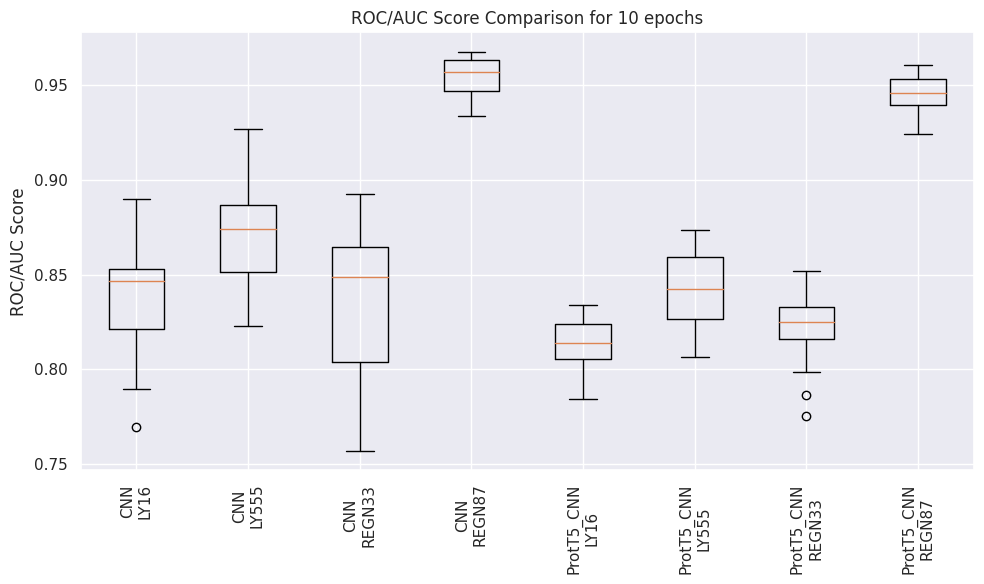

In [18]:
# Print the results
for model, scores in results_10_epochs.items():
    print(f"{model} model:")
    for antibody, score in scores.items():
        print(f"{antibody}: {score}")

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as per your needs
model_names = list(results_10_epochs.keys())
data = [results[model_name][antibody] for model_name in model_names for antibody in antibodies]
boxplot = ax.boxplot(data, labels=[f"{model_name}\n{antibody}" for model_name in model_names for antibody in antibodies])

# Rotate the labels
plt.xticks(rotation=90)

plt.title('ROC/AUC Score Comparison for 10 epochs')
plt.ylabel('ROC/AUC Score')
plt.tight_layout()  # Adjust the layout to prevent overlapping labels
plt.savefig('10_epochs_final_plot.png')
plt.show()

In [22]:
import csv
# Save the results as a CSV file
with open('results_10_epochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for key, value in results_10_epochs.items():
        writer.writerow([key, value])

In [15]:
models_5_epochs = {
    "CNN": ConvNet(),
    "ProtT5_CNN": ConvNet1D()
}

results_5_epochs = {model: {antibody: [] for antibody in antibodies} for model in models_10_epochs}

from tqdm import tqdm

for i, (train_antibody, test_antibody, train_embedding, test_embedding) in tqdm(enumerate(zip(train_antibodies, test_antibodies, train_embeddings, test_embeddings)), total=len(train_antibodies)):
    for _ in tqdm(range(5)):
        for model_name, model in models_5_epochs.items():
            if model_name == "ProtT5_CNN" or model_name == "ProtT5_XGBoost":
                train_loader = prepare_t5_data(train_embedding, sample_size=1000)
                test_loader = prepare_t5_data(test_embedding, sample_size=1000)
            else:
                train_loader = prepare_data(train_antibody, sample_size=1000)
                test_loader = prepare_data(test_antibody, sample_size=1000)

            if model_name == "XGBoost" or model_name == "ProtT5_XGBoost":
                # Flatten the sequences
                X_train = torch.vstack([x for x, y in train_loader]).reshape(-1, 1024).numpy() if model_name == "ProtT5_XGBoost" else torch.vstack([x for x, y in train_loader]).reshape(-1, 24*20).numpy()
                y_train = torch.hstack([y for x, y in train_loader]).numpy()
                X_test = torch.vstack([x for x, y in test_loader]).reshape(-1, 1024).numpy() if model_name == "ProtT5_XGBoost" else torch.vstack([x for x, y in test_loader]).reshape(-1, 24*20).numpy()
                y_test = torch.hstack([y for x, y in test_loader]).numpy()

                # Train the XGBoost model
                model.fit(X_train, y_train)

                # Predict on test set
                y_pred = model.predict_proba(X_test)[:, 1]

                # Calculate ROC/AUC score
                score = roc_auc_score(y_test, y_pred)
            else:
                # Handle other models (CNN and ProtT5_CNN) similarly
                criterion = nn.BCEWithLogitsLoss()
                learning_rate = 1e-3
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                model = model.to(device)
                score = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10)
            results[model_name][antibodies[i]].append(score)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.6221
Epoch 2/10, Training Loss: 0.4666
Epoch 3/10, Training Loss: 0.4002
Epoch 4/10, Training Loss: 0.3487
Epoch 5/10, Training Loss: 0.3052
Epoch 6/10, Training Loss: 0.2713
Epoch 7/10, Training Loss: 0.2439
Epoch 8/10, Training Loss: 0.2072
Epoch 9/10, Training Loss: 0.1775
Epoch 10/10, Training Loss: 0.1532
ROC/AUC Score: 0.8459
Epoch 1/10, Training Loss: 0.6298
Epoch 2/10, Training Loss: 0.4615
Epoch 3/10, Training Loss: 0.3843
Epoch 4/10, Training Loss: 0.3193
Epoch 5/10, Training Loss: 0.2551
Epoch 6/10, Training Loss: 0.1867
Epoch 7/10, Training Loss: 0.1622
Epoch 8/10, Training Loss: 0.1259
Epoch 9/10, Training Loss: 0.0991
Epoch 10/10, Training Loss: 0.1104



 20%|██        | 1/5 [00:04<00:19,  4.84s/it]

ROC/AUC Score: 0.8266
Epoch 1/10, Training Loss: 0.6166
Epoch 2/10, Training Loss: 0.4743
Epoch 3/10, Training Loss: 0.4094
Epoch 4/10, Training Loss: 0.3478
Epoch 5/10, Training Loss: 0.3197
Epoch 6/10, Training Loss: 0.2686
Epoch 7/10, Training Loss: 0.2430
Epoch 8/10, Training Loss: 0.2107
Epoch 9/10, Training Loss: 0.1854
Epoch 10/10, Training Loss: 0.1684
ROC/AUC Score: 0.8899
Epoch 1/10, Training Loss: 0.5803
Epoch 2/10, Training Loss: 0.4387
Epoch 3/10, Training Loss: 0.3676
Epoch 4/10, Training Loss: 0.2941
Epoch 5/10, Training Loss: 0.2240
Epoch 6/10, Training Loss: 0.2098
Epoch 7/10, Training Loss: 0.1877
Epoch 8/10, Training Loss: 0.1574
Epoch 9/10, Training Loss: 0.1171
Epoch 10/10, Training Loss: 0.1149



 40%|████      | 2/5 [00:08<00:13,  4.39s/it]

ROC/AUC Score: 0.7993
Epoch 1/10, Training Loss: 0.6435
Epoch 2/10, Training Loss: 0.4929
Epoch 3/10, Training Loss: 0.4359
Epoch 4/10, Training Loss: 0.3858
Epoch 5/10, Training Loss: 0.3351
Epoch 6/10, Training Loss: 0.2903
Epoch 7/10, Training Loss: 0.2583
Epoch 8/10, Training Loss: 0.2239
Epoch 9/10, Training Loss: 0.1995
Epoch 10/10, Training Loss: 0.1834
ROC/AUC Score: 0.8313
Epoch 1/10, Training Loss: 0.6306
Epoch 2/10, Training Loss: 0.4777
Epoch 3/10, Training Loss: 0.3972
Epoch 4/10, Training Loss: 0.3078
Epoch 5/10, Training Loss: 0.2590
Epoch 6/10, Training Loss: 0.2050
Epoch 7/10, Training Loss: 0.1512
Epoch 8/10, Training Loss: 0.1676
Epoch 9/10, Training Loss: 0.1097
Epoch 10/10, Training Loss: 0.1015



 60%|██████    | 3/5 [00:14<00:09,  4.79s/it]

ROC/AUC Score: 0.8200
Epoch 1/10, Training Loss: 0.6371
Epoch 2/10, Training Loss: 0.5100
Epoch 3/10, Training Loss: 0.4437
Epoch 4/10, Training Loss: 0.3937
Epoch 5/10, Training Loss: 0.3434
Epoch 6/10, Training Loss: 0.3072
Epoch 7/10, Training Loss: 0.2862
Epoch 8/10, Training Loss: 0.2516
Epoch 9/10, Training Loss: 0.2142
Epoch 10/10, Training Loss: 0.1989
ROC/AUC Score: 0.8463
Epoch 1/10, Training Loss: 0.6280
Epoch 2/10, Training Loss: 0.4721
Epoch 3/10, Training Loss: 0.3778
Epoch 4/10, Training Loss: 0.2902
Epoch 5/10, Training Loss: 0.2499
Epoch 6/10, Training Loss: 0.2069
Epoch 7/10, Training Loss: 0.1883
Epoch 8/10, Training Loss: 0.2127
Epoch 9/10, Training Loss: 0.1389
Epoch 10/10, Training Loss: 0.0772



 80%|████████  | 4/5 [00:18<00:04,  4.50s/it]

ROC/AUC Score: 0.8093
Epoch 1/10, Training Loss: 0.6269
Epoch 2/10, Training Loss: 0.5269
Epoch 3/10, Training Loss: 0.4647
Epoch 4/10, Training Loss: 0.4241
Epoch 5/10, Training Loss: 0.3767
Epoch 6/10, Training Loss: 0.3425
Epoch 7/10, Training Loss: 0.3021
Epoch 8/10, Training Loss: 0.2749
Epoch 9/10, Training Loss: 0.2530
Epoch 10/10, Training Loss: 0.2325
ROC/AUC Score: 0.7698
Epoch 1/10, Training Loss: 0.5784
Epoch 2/10, Training Loss: 0.4280
Epoch 3/10, Training Loss: 0.3624
Epoch 4/10, Training Loss: 0.2944
Epoch 5/10, Training Loss: 0.2126
Epoch 6/10, Training Loss: 0.1876
Epoch 7/10, Training Loss: 0.1415
Epoch 8/10, Training Loss: 0.1236
Epoch 9/10, Training Loss: 0.1047
Epoch 10/10, Training Loss: 0.0653



 25%|██▌       | 1/4 [00:22<01:07, 22.47s/it]

ROC/AUC Score: 0.8221



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.5985
Epoch 2/10, Training Loss: 0.4739
Epoch 3/10, Training Loss: 0.4084
Epoch 4/10, Training Loss: 0.3688
Epoch 5/10, Training Loss: 0.3227
Epoch 6/10, Training Loss: 0.3037
Epoch 7/10, Training Loss: 0.2764
Epoch 8/10, Training Loss: 0.2503
Epoch 9/10, Training Loss: 0.2425
Epoch 10/10, Training Loss: 0.2061
ROC/AUC Score: 0.8646
Epoch 1/10, Training Loss: 0.6167
Epoch 2/10, Training Loss: 0.4568
Epoch 3/10, Training Loss: 0.3617
Epoch 4/10, Training Loss: 0.3307
Epoch 5/10, Training Loss: 0.2694
Epoch 6/10, Training Loss: 0.2013
Epoch 7/10, Training Loss: 0.1545
Epoch 8/10, Training Loss: 0.1512
Epoch 9/10, Training Loss: 0.1088
Epoch 10/10, Training Loss: 0.1219



 20%|██        | 1/5 [00:05<00:21,  5.28s/it]

ROC/AUC Score: 0.8269
Epoch 1/10, Training Loss: 0.6143
Epoch 2/10, Training Loss: 0.4626
Epoch 3/10, Training Loss: 0.3932
Epoch 4/10, Training Loss: 0.3426
Epoch 5/10, Training Loss: 0.3039
Epoch 6/10, Training Loss: 0.2733
Epoch 7/10, Training Loss: 0.2454
Epoch 8/10, Training Loss: 0.2175
Epoch 9/10, Training Loss: 0.1885
Epoch 10/10, Training Loss: 0.1638
ROC/AUC Score: 0.8231
Epoch 1/10, Training Loss: 0.6212
Epoch 2/10, Training Loss: 0.4558
Epoch 3/10, Training Loss: 0.3815
Epoch 4/10, Training Loss: 0.3171
Epoch 5/10, Training Loss: 0.2462
Epoch 6/10, Training Loss: 0.2022
Epoch 7/10, Training Loss: 0.1483
Epoch 8/10, Training Loss: 0.1294
Epoch 9/10, Training Loss: 0.1219
Epoch 10/10, Training Loss: 0.1008



 40%|████      | 2/5 [00:09<00:13,  4.57s/it]

ROC/AUC Score: 0.8213
Epoch 1/10, Training Loss: 0.5933
Epoch 2/10, Training Loss: 0.4623
Epoch 3/10, Training Loss: 0.4028
Epoch 4/10, Training Loss: 0.3514
Epoch 5/10, Training Loss: 0.3088
Epoch 6/10, Training Loss: 0.2725
Epoch 7/10, Training Loss: 0.2441
Epoch 8/10, Training Loss: 0.2129
Epoch 9/10, Training Loss: 0.1956
Epoch 10/10, Training Loss: 0.1671
ROC/AUC Score: 0.8516
Epoch 1/10, Training Loss: 0.6287
Epoch 2/10, Training Loss: 0.4803
Epoch 3/10, Training Loss: 0.4151
Epoch 4/10, Training Loss: 0.3296
Epoch 5/10, Training Loss: 0.2866
Epoch 6/10, Training Loss: 0.2430
Epoch 7/10, Training Loss: 0.1930
Epoch 8/10, Training Loss: 0.1868
Epoch 9/10, Training Loss: 0.1555
Epoch 10/10, Training Loss: 0.1056



 60%|██████    | 3/5 [00:13<00:08,  4.38s/it]

ROC/AUC Score: 0.8138
Epoch 1/10, Training Loss: 0.5763
Epoch 2/10, Training Loss: 0.4452
Epoch 3/10, Training Loss: 0.3911
Epoch 4/10, Training Loss: 0.3363
Epoch 5/10, Training Loss: 0.2969
Epoch 6/10, Training Loss: 0.2646
Epoch 7/10, Training Loss: 0.2495
Epoch 8/10, Training Loss: 0.2174
Epoch 9/10, Training Loss: 0.1845
Epoch 10/10, Training Loss: 0.1729
ROC/AUC Score: 0.9132
Epoch 1/10, Training Loss: 0.6334
Epoch 2/10, Training Loss: 0.4636
Epoch 3/10, Training Loss: 0.3997
Epoch 4/10, Training Loss: 0.3218
Epoch 5/10, Training Loss: 0.2372
Epoch 6/10, Training Loss: 0.1735
Epoch 7/10, Training Loss: 0.1541
Epoch 8/10, Training Loss: 0.1299
Epoch 9/10, Training Loss: 0.1143
Epoch 10/10, Training Loss: 0.0815



 80%|████████  | 4/5 [00:18<00:04,  4.79s/it]

ROC/AUC Score: 0.8587
Epoch 1/10, Training Loss: 0.6136
Epoch 2/10, Training Loss: 0.4829
Epoch 3/10, Training Loss: 0.4274
Epoch 4/10, Training Loss: 0.3895
Epoch 5/10, Training Loss: 0.3528
Epoch 6/10, Training Loss: 0.3120
Epoch 7/10, Training Loss: 0.2922
Epoch 8/10, Training Loss: 0.2540
Epoch 9/10, Training Loss: 0.2355
Epoch 10/10, Training Loss: 0.2120
ROC/AUC Score: 0.8739
Epoch 1/10, Training Loss: 0.6160
Epoch 2/10, Training Loss: 0.4502
Epoch 3/10, Training Loss: 0.3388
Epoch 4/10, Training Loss: 0.2805
Epoch 5/10, Training Loss: 0.2128
Epoch 6/10, Training Loss: 0.1778
Epoch 7/10, Training Loss: 0.1719
Epoch 8/10, Training Loss: 0.1591
Epoch 9/10, Training Loss: 0.1324
Epoch 10/10, Training Loss: 0.1138



 50%|█████     | 2/4 [00:45<00:45, 22.80s/it]

ROC/AUC Score: 0.8422



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.6174
Epoch 2/10, Training Loss: 0.4550
Epoch 3/10, Training Loss: 0.3803
Epoch 4/10, Training Loss: 0.3263
Epoch 5/10, Training Loss: 0.2783
Epoch 6/10, Training Loss: 0.2416
Epoch 7/10, Training Loss: 0.2042
Epoch 8/10, Training Loss: 0.1716
Epoch 9/10, Training Loss: 0.1492
Epoch 10/10, Training Loss: 0.1305
ROC/AUC Score: 0.8321
Epoch 1/10, Training Loss: 0.6327
Epoch 2/10, Training Loss: 0.4724
Epoch 3/10, Training Loss: 0.3713
Epoch 4/10, Training Loss: 0.2925
Epoch 5/10, Training Loss: 0.2468
Epoch 6/10, Training Loss: 0.1691
Epoch 7/10, Training Loss: 0.1665
Epoch 8/10, Training Loss: 0.1578
Epoch 9/10, Training Loss: 0.1121
Epoch 10/10, Training Loss: 0.0897



 20%|██        | 1/5 [00:04<00:16,  4.14s/it]

ROC/AUC Score: 0.8242
Epoch 1/10, Training Loss: 0.6374
Epoch 2/10, Training Loss: 0.5244
Epoch 3/10, Training Loss: 0.4608
Epoch 4/10, Training Loss: 0.4106
Epoch 5/10, Training Loss: 0.3631
Epoch 6/10, Training Loss: 0.3222
Epoch 7/10, Training Loss: 0.2805
Epoch 8/10, Training Loss: 0.2547
Epoch 9/10, Training Loss: 0.2182
Epoch 10/10, Training Loss: 0.1862
ROC/AUC Score: 0.8593
Epoch 1/10, Training Loss: 0.6133
Epoch 2/10, Training Loss: 0.4480
Epoch 3/10, Training Loss: 0.3806
Epoch 4/10, Training Loss: 0.2721
Epoch 5/10, Training Loss: 0.2090
Epoch 6/10, Training Loss: 0.1851
Epoch 7/10, Training Loss: 0.1193
Epoch 8/10, Training Loss: 0.1416
Epoch 9/10, Training Loss: 0.1098
Epoch 10/10, Training Loss: 0.0817



 40%|████      | 2/5 [00:09<00:14,  4.87s/it]

ROC/AUC Score: 0.8266
Epoch 1/10, Training Loss: 0.6189
Epoch 2/10, Training Loss: 0.4856
Epoch 3/10, Training Loss: 0.4257
Epoch 4/10, Training Loss: 0.3746
Epoch 5/10, Training Loss: 0.3328
Epoch 6/10, Training Loss: 0.2854
Epoch 7/10, Training Loss: 0.2594
Epoch 8/10, Training Loss: 0.2143
Epoch 9/10, Training Loss: 0.1875
Epoch 10/10, Training Loss: 0.1669
ROC/AUC Score: 0.8858
Epoch 1/10, Training Loss: 0.6746
Epoch 2/10, Training Loss: 0.5071
Epoch 3/10, Training Loss: 0.4277
Epoch 4/10, Training Loss: 0.3413
Epoch 5/10, Training Loss: 0.2856
Epoch 6/10, Training Loss: 0.2673
Epoch 7/10, Training Loss: 0.2066
Epoch 8/10, Training Loss: 0.1308
Epoch 9/10, Training Loss: 0.1126
Epoch 10/10, Training Loss: 0.0973



 60%|██████    | 3/5 [00:13<00:08,  4.50s/it]

ROC/AUC Score: 0.7988
Epoch 1/10, Training Loss: 0.5941
Epoch 2/10, Training Loss: 0.4719
Epoch 3/10, Training Loss: 0.4133
Epoch 4/10, Training Loss: 0.3718
Epoch 5/10, Training Loss: 0.3323
Epoch 6/10, Training Loss: 0.2920
Epoch 7/10, Training Loss: 0.2613
Epoch 8/10, Training Loss: 0.2364
Epoch 9/10, Training Loss: 0.1934
Epoch 10/10, Training Loss: 0.1896
ROC/AUC Score: 0.8817
Epoch 1/10, Training Loss: 0.6243
Epoch 2/10, Training Loss: 0.5013
Epoch 3/10, Training Loss: 0.4041
Epoch 4/10, Training Loss: 0.3112
Epoch 5/10, Training Loss: 0.2586
Epoch 6/10, Training Loss: 0.1788
Epoch 7/10, Training Loss: 0.1728
Epoch 8/10, Training Loss: 0.1697
Epoch 9/10, Training Loss: 0.1077
Epoch 10/10, Training Loss: 0.1151



 80%|████████  | 4/5 [00:17<00:04,  4.33s/it]

ROC/AUC Score: 0.8304
Epoch 1/10, Training Loss: 0.6471
Epoch 2/10, Training Loss: 0.5273
Epoch 3/10, Training Loss: 0.4677
Epoch 4/10, Training Loss: 0.4211
Epoch 5/10, Training Loss: 0.3756
Epoch 6/10, Training Loss: 0.3305
Epoch 7/10, Training Loss: 0.2929
Epoch 8/10, Training Loss: 0.2710
Epoch 9/10, Training Loss: 0.2275
Epoch 10/10, Training Loss: 0.2042
ROC/AUC Score: 0.8488
Epoch 1/10, Training Loss: 0.6304
Epoch 2/10, Training Loss: 0.4593
Epoch 3/10, Training Loss: 0.3601
Epoch 4/10, Training Loss: 0.2932
Epoch 5/10, Training Loss: 0.2012
Epoch 6/10, Training Loss: 0.1449
Epoch 7/10, Training Loss: 0.1410
Epoch 8/10, Training Loss: 0.1293
Epoch 9/10, Training Loss: 0.1078
Epoch 10/10, Training Loss: 0.1024



 75%|███████▌  | 3/4 [01:08<00:22, 22.96s/it]

ROC/AUC Score: 0.8245



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.4426
Epoch 2/10, Training Loss: 0.2937
Epoch 3/10, Training Loss: 0.2508
Epoch 4/10, Training Loss: 0.2223
Epoch 5/10, Training Loss: 0.1953
Epoch 6/10, Training Loss: 0.1757
Epoch 7/10, Training Loss: 0.1460
Epoch 8/10, Training Loss: 0.1419
Epoch 9/10, Training Loss: 0.1205
Epoch 10/10, Training Loss: 0.1143
ROC/AUC Score: 0.9571
Epoch 1/10, Training Loss: 0.4317
Epoch 2/10, Training Loss: 0.2688
Epoch 3/10, Training Loss: 0.2049
Epoch 4/10, Training Loss: 0.1572
Epoch 5/10, Training Loss: 0.1455
Epoch 6/10, Training Loss: 0.1000
Epoch 7/10, Training Loss: 0.0782
Epoch 8/10, Training Loss: 0.0617
Epoch 9/10, Training Loss: 0.0581
Epoch 10/10, Training Loss: 0.0804



 20%|██        | 1/5 [00:04<00:17,  4.40s/it]

ROC/AUC Score: 0.9294
Epoch 1/10, Training Loss: 0.4729
Epoch 2/10, Training Loss: 0.3015
Epoch 3/10, Training Loss: 0.2609
Epoch 4/10, Training Loss: 0.2243
Epoch 5/10, Training Loss: 0.2099
Epoch 6/10, Training Loss: 0.1834
Epoch 7/10, Training Loss: 0.1644
Epoch 8/10, Training Loss: 0.1437
Epoch 9/10, Training Loss: 0.1291
Epoch 10/10, Training Loss: 0.1208
ROC/AUC Score: 0.9339
Epoch 1/10, Training Loss: 0.3898
Epoch 2/10, Training Loss: 0.2192
Epoch 3/10, Training Loss: 0.1653
Epoch 4/10, Training Loss: 0.1184
Epoch 5/10, Training Loss: 0.1015
Epoch 6/10, Training Loss: 0.0868
Epoch 7/10, Training Loss: 0.0599
Epoch 8/10, Training Loss: 0.0641
Epoch 9/10, Training Loss: 0.0479
Epoch 10/10, Training Loss: 0.0427



 40%|████      | 2/5 [00:08<00:12,  4.24s/it]

ROC/AUC Score: 0.9609
Epoch 1/10, Training Loss: 0.4973
Epoch 2/10, Training Loss: 0.3180
Epoch 3/10, Training Loss: 0.2793
Epoch 4/10, Training Loss: 0.2473
Epoch 5/10, Training Loss: 0.2265
Epoch 6/10, Training Loss: 0.1902
Epoch 7/10, Training Loss: 0.1920
Epoch 8/10, Training Loss: 0.1636
Epoch 9/10, Training Loss: 0.1453
Epoch 10/10, Training Loss: 0.1317
ROC/AUC Score: 0.9645
Epoch 1/10, Training Loss: 0.3711
Epoch 2/10, Training Loss: 0.2115
Epoch 3/10, Training Loss: 0.1502
Epoch 4/10, Training Loss: 0.0967
Epoch 5/10, Training Loss: 0.0624
Epoch 6/10, Training Loss: 0.0861
Epoch 7/10, Training Loss: 0.0959
Epoch 8/10, Training Loss: 0.0556
Epoch 9/10, Training Loss: 0.0347
Epoch 10/10, Training Loss: 0.0260



 60%|██████    | 3/5 [00:13<00:09,  4.74s/it]

ROC/AUC Score: 0.9493
Epoch 1/10, Training Loss: 0.4615
Epoch 2/10, Training Loss: 0.3303
Epoch 3/10, Training Loss: 0.2834
Epoch 4/10, Training Loss: 0.2525
Epoch 5/10, Training Loss: 0.2247
Epoch 6/10, Training Loss: 0.2075
Epoch 7/10, Training Loss: 0.1799
Epoch 8/10, Training Loss: 0.1579
Epoch 9/10, Training Loss: 0.1430
Epoch 10/10, Training Loss: 0.1288
ROC/AUC Score: 0.9631
Epoch 1/10, Training Loss: 0.3659
Epoch 2/10, Training Loss: 0.2192
Epoch 3/10, Training Loss: 0.1715
Epoch 4/10, Training Loss: 0.1241
Epoch 5/10, Training Loss: 0.1056
Epoch 6/10, Training Loss: 0.0790
Epoch 7/10, Training Loss: 0.0890
Epoch 8/10, Training Loss: 0.0954
Epoch 9/10, Training Loss: 0.0648
Epoch 10/10, Training Loss: 0.0386



 80%|████████  | 4/5 [00:17<00:04,  4.49s/it]

ROC/AUC Score: 0.9488
Epoch 1/10, Training Loss: 0.5108
Epoch 2/10, Training Loss: 0.3281
Epoch 3/10, Training Loss: 0.2787
Epoch 4/10, Training Loss: 0.2354
Epoch 5/10, Training Loss: 0.2045
Epoch 6/10, Training Loss: 0.1833
Epoch 7/10, Training Loss: 0.1788
Epoch 8/10, Training Loss: 0.1468
Epoch 9/10, Training Loss: 0.1263
Epoch 10/10, Training Loss: 0.1090
ROC/AUC Score: 0.9674
Epoch 1/10, Training Loss: 0.4090
Epoch 2/10, Training Loss: 0.2612
Epoch 3/10, Training Loss: 0.2112
Epoch 4/10, Training Loss: 0.1515
Epoch 5/10, Training Loss: 0.1127
Epoch 6/10, Training Loss: 0.0959
Epoch 7/10, Training Loss: 0.0775
Epoch 8/10, Training Loss: 0.0655
Epoch 9/10, Training Loss: 0.0484
Epoch 10/10, Training Loss: 0.0397



100%|██████████| 4/4 [01:30<00:00, 22.70s/it]

ROC/AUC Score: 0.9242


CNN model:
LY16: []
LY555: []
REGN33: []
REGN87: []
ProtT5_CNN model:
LY16: []
LY555: []
REGN33: []
REGN87: []


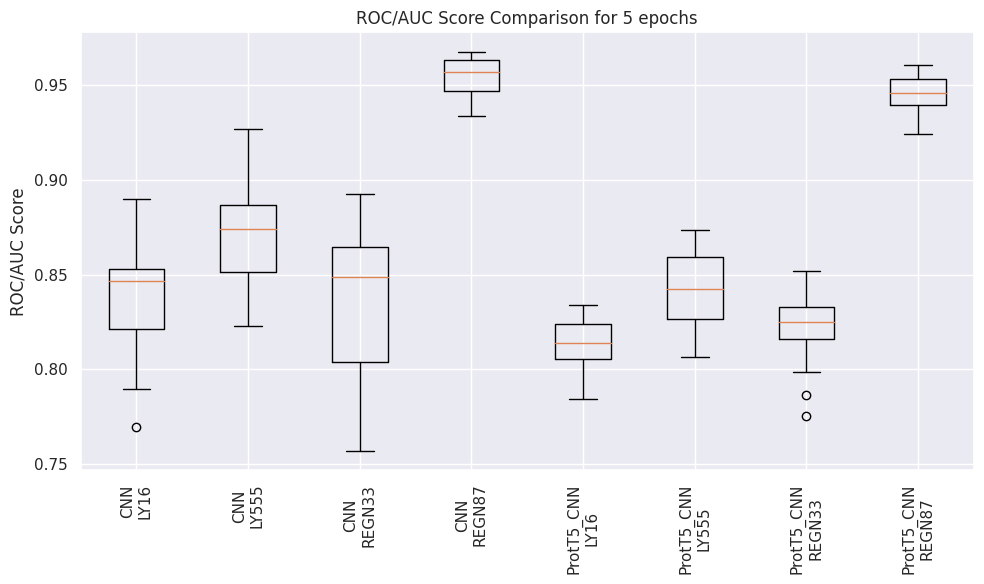

In [17]:
# Print the results
for model, scores in results_5_epochs.items():
    print(f"{model} model:")
    for antibody, score in scores.items():
        print(f"{antibody}: {score}")

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as per your needs
model_names = list(results_5_epochs.keys())
data = [results[model_name][antibody] for model_name in model_names for antibody in antibodies]
boxplot = ax.boxplot(data, labels=[f"{model_name}\n{antibody}" for model_name in model_names for antibody in antibodies])

# Rotate the labels
plt.xticks(rotation=90)

plt.title('ROC/AUC Score Comparison for 5 epochs')
plt.ylabel('ROC/AUC Score')
plt.tight_layout()  # Adjust the layout to prevent overlapping labels
plt.savefig('5_epochs_final_plot.png')
plt.show()

In [24]:
import csv
# Save the results as a CSV file
with open('results_5_epochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for key, value in results_5_epochs.items():
        writer.writerow([key, value])